# Segmentation of Road from Satellite imagery

## Importing Libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')

!pip install tensorflow==1.14.0

import os
import cv2
#from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
from keras import backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/MapSegClean/'
/content/gdrive/My Drive/MapSegClean


## Defining Custom Loss functions and accuracy Metric.

In [0]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Defining Our Model

In [0]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
import keras

In [0]:
inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

RuntimeError: ignored

### HYPER_PARAMETERS

In [0]:
LEARNING_RATE = 0.0001

### Initializing Callbacks

In [0]:
#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [0]:
model_path = "./Models/colab_weights.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

### Compiling the model

In [0]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [0]:
model.save('/content/gdrive/My Drive/MapSegClean/Models/model.h5')

In [0]:
import keras.losses, keras.metrics
keras.losses.soft_dice_loss = soft_dice_loss
keras.metrics.iou_coef = iou_coef

In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/MapSegClean/Models/model.h5',
                   custom_objects={'loss': soft_dice_loss})







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




## Testing our Model

### On Test Images

In [0]:
model.load_weights("/content/gdrive/My Drive/MapSegClean/Models/Final_unet_road_weights.h5")

In [0]:
import cv2
import glob
import numpy as np
import h5py

#test_images = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/I/")])
#test_masks = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/M/")])
test_masks = []
test_images = []
files = glob.glob ("TestI/*.png")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    test_images.append (image)
    myFile = 'TestM' + myFile[5:len(myFile)]
    image = cv2.cvtColor(cv2.imread (myFile), cv2.COLOR_BGR2GRAY)
    test_masks.append (image)


#files = glob.glob ("TestM/*.png")
#for myFile in files:
#    print(myFile)

    
#test_images = cv2.imread("/home/bisag/Desktop/Road-Segmentation/I/1.png")
#test_masks = cv2.imread("/home/bisag/Desktop/Road-Segmentation/M/1.png")

test_images = np.array(test_images)
test_masks = np.array(test_masks)

test_masks = np.expand_dims(test_masks, -1)
print("Unique elements in the train mask:", np.unique(test_masks))

print(test_images.shape)
print(test_masks.shape)


TestI/10378690_15_24.png
TestI/10378690_15_4.png
TestI/10228705_15_22.png
TestI/10378675_15_14.png
TestI/10078690_15_18.png
TestI/10228660_15_20.png
TestI/10378675_15_4.png
TestI/10078735_15_25.png
TestI/10228675_15_22.png
TestI/10078690_15_16.png
TestI/10228735_15_20.png
TestI/10078720_15_14.png
TestI/10378675_15_24.png
TestI/10378690_15_5.png
TestI/10078660_15_4.png
TestI/10228705_15_24.png
TestI/10228735_15_13.png
TestI/10228720_15_2.png
TestI/10378660_15_19.png
TestI/10378675_15_13.png
TestI/10228705_15_7.png
TestI/10228765_15_25.png
TestI/10228675_15_6.png
TestI/10228675_15_9.png
TestI/10228720_15_16.png
TestI/10228705_15_19.png
TestI/10228750_15_12.png
TestI/10078720_15_18.png
TestI/10228675_15_14.png
TestI/10228750_15_5.png
Unique elements in the train mask: [  0 255]
(30, 256, 256, 3)
(30, 256, 256, 1)


In [0]:
!pip list | grep cv

cvxopt                   1.2.4          
cvxpy                    1.0.28         
opencv-contrib-python    4.1.2.30       
opencv-python            4.1.2.30       


In [0]:
model.evaluate(test_images, test_masks)

30/30 [==============================] - 5s 162ms/step


[-0.6959566473960876, 7.662191390991211]

In [0]:
predictions = model.predict(test_images, verbose=1)*255

30/30 [==============================] - 4s 140ms/step


In [0]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

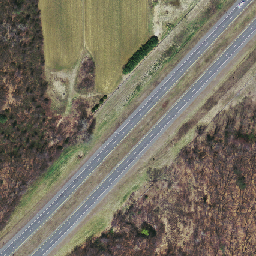

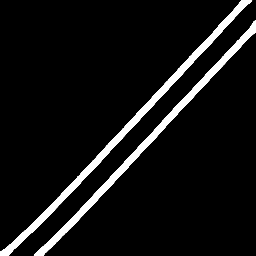

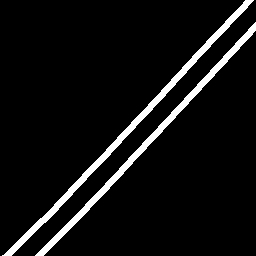

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(np.squeeze(test_images[0]))
cv2_imshow(np.squeeze(predictions[0]))
cv2_imshow(np.squeeze(test_masks[0]))


In [0]:
import matplotlib

for i in range(len(predictions)):
    print(i)
    cv2.imwrite( "Results/" + str(i) + "Image.png"  , test_images[i])
    cv2.imwrite( "Results/" + str(i) + "GroundTruth.png"  , test_masks[i])
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))
    #matplotlib.image.imsave('/home/bisag/Desktop/Road-Segmentation/Results/000.png', np.squeeze(predicton_threshold[0][:,:,0]))
    matplotlib.image.imsave("Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    matplotlib.image.imsave( "Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))

    #imshow(np.squeeze(predictions[0][:,:,0]))


#import scipy.misc
#scipy.misc.imsave('/home/bisag/Desktop/Road-Segmentation/Results/00.png', np.squeeze(predictions[0][:,:,0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [0]:
model.load_weights("/home/parshwa/Desktop/Road-Segmentation/Models/weights.h5")

### Just Test

In [0]:
"""Test"""
import cv2
import glob
import numpy as np
import h5py

#test_images = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/I/")])
#test_masks = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/M/")])

test_images = []
files = glob.glob ("/home/parshwa/Desktop/Road-Segmentation/Test/*.png")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    test_images.append (image)


    
#test_images = cv2.imread("/home/bisag/Desktop/Road-Segmentation/I/1.png")
#test_masks = cv2.imread("/home/bisag/Desktop/Road-Segmentation/M/1.png")

test_images = np.array(test_images)

print(test_images.shape)



(0,)


In [0]:
predictions = model.predict(test_images, verbose=1)

ValueError: ignored

In [0]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

In [0]:
import matplotlib

for i in range(len(predictions)):
    cv2.imwrite( "/home/parshwa/Desktop/Road-Segmentation/Results/" + str(i) + "Image.png"  , np.squeeze(test_images[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))
    #matplotlib.image.imsave('/home/bisag/Desktop/Road-Segmentation/Results/000.png', np.squeeze(predicton_threshold[0][:,:,0]))
    matplotlib.image.imsave("/home/parshwa/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    matplotlib.image.imsave( "/home/parshwa/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))

    #imshow(np.squeeze(predictions[0][:,:,0]))

imshow(np.squeeze(predictions[0][:,:,0]))

#import scipy.misc
#scipy.misc.imsave('/home/bisag/Desktop/Road-Segmentation/Results/00.png', np.squeeze(predictions[0][:,:,0]))

NameError: name 'predicton_threshold' is not defined

In [0]:
"""Visualise"""
def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')
